<a href="https://colab.research.google.com/github/sir-sauc3/Project2/blob/main/Trial_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random
from scipy.signal import correlate2d

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.colors as colors

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [15]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(9, 9)): #frames=50, steps_per_frame=1, figsize=(8, 8)
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=0.4):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [4]:
class Deer:

  def __init__(self, location, weight=30, **grid_size):
    self.location = tuple(location)
    self.weight = weight
    self.gridsize= grid_size['grid_size']

  def cardinal_neighbors(self):
    x = self.location[0]
    y = self.location[1]
    return [((x-1)%self.gridsize, y), (x, (y+1)%self.gridsize), ((x+1)%self.gridsize, y), (x, (y-1)%self.gridsize)]

In [24]:
class Grazing_simulation:


  cmap = [(1, 0.5, 0), (0, 1, 0)]
  grazing_colour_map = matplotlib.colors.ListedColormap(cmap)


  def __init__(self, size, coverage, num_deer, regrowth_rate=0.25, max_weight=50, metabolism=10, regrowth_interval=5):
      self.size = size
      self.coverage = coverage
      self.num_deer = num_deer
      self.regrowth_rate = regrowth_rate
      self.max_weight = max_weight
      self.metabolism = metabolism
      self.regrowth_interval = regrowth_interval
      self.step_count = 0

      self.grassland = np.random.choice([1,0], (size,size), p=(coverage, 1-coverage))
      self.introduce_deer()

  def calculate_weights(self, deer):
      weights = []
      for neighbor in deer.cardinal_neighbors():
          x, y = neighbor
          if self.grassland[y][x] == 1:
              weight = 1
          else:
              weight = 0
          weights.append(weight)
      return weights


  def introduce_deer(self):
      locs = [(x,y) for x in range(self.size) for y in range(self.size)]
      np.random.shuffle(locs)

      assert(self.num_deer <= len(locs))
      self.deers = [Deer(locs[i], grid_size = self.size) for i in range(self.num_deer)]


  def move_deer(self, deer):      
    weights = self.calculate_weights(deer)
    max_weight = max(weights)
    best_neighbors = [i for i, w in enumerate(weights) if w == max_weight]
    available_to_move = [(x,y) for i, (x,y) in enumerate(deer.cardinal_neighbors()) if i in best_neighbors and (x,y) not in self.occupied_locations]

    if (len(available_to_move) > 0):
        self.occupied_locations.remove(deer.location)
        deer.location = random.choice(available_to_move)
        self.occupied_locations.append(deer.location)
    else:
        return

    x, y = deer.location
    if self.grassland[y][x] == 1:
        deer.weight += self.metabolism #A POSSIBLE PARAMETER TO CHANGE FOR SUSTAINABILITY EXPERIMENT
        self.grassland[y][x] = 0
    else:
        deer.weight -= self.metabolism * 1.5 #A POSSIBLE PARAMETER TO CHANGE FOR SUSTAINABILITY EXPERIMENT
        if deer.weight <= 0:
            self.deers.remove(deer)




  def step(self):
    self.occupied_locations = [deer.location for deer in self.deers]
    other_locs = {}

    self.step_count += 1
    if self.step_count % self.regrowth_interval == 0:
      regrowth_mask = np.random.choice([0,1], (self.size,self.size), p=(1-self.regrowth_rate, self.regrowth_rate))
      self.grassland = np.clip(self.grassland + regrowth_mask, 0, 1)

    for deer in self.deers:
      self.move_deer(deer)
      xs, ys = deer.location
      other_locs.update({(xs,ys):deer.weight})
      points = plt.plot(xs, ys, '.', color='brown', markersize=10)
    print(f'weights at each time step: {other_locs}')
    print("---------------------------------------------------------------------------------------")


  def draw(self, axes=None, step=''):
      """Draws the CA cells using the forest colour map so values are coloured intuitively."""
      axes = axes or plt.axes
      title = f'Time:{step}\nNumber of deer present: {len(self.deers)}'
      plot_2D_array(self.grassland, axes=axes, title=title,
                    cmap=self.grazing_colour_map, vmin=0, vmax=len(self.grazing_colour_map.colors))

weights at each time step: {(45, 30): 420.0, (65, 2): 345.0, (16, 66): 395.0, (20, 17): 370.0, (29, 95): 420.0, (73, 85): 270.0, (5, 24): 445.0, (6, 74): 320.0, (15, 97): 410.0, (75, 36): 485.0, (13, 56): 335.0, (0, 48): 320.0, (78, 88): 410.0, (75, 92): 195.0, (64, 36): 470.0, (11, 35): 435.0, (32, 18): 295.0, (30, 75): 335.0, (67, 55): 370.0, (14, 13): 420.0, (43, 48): 420.0, (86, 17): 270.0, (72, 48): 370.0, (32, 83): 445.0, (60, 96): 420.0, (92, 30): 300.0, (2, 23): 285.0, (96, 62): 460.0, (94, 12): 310.0, (60, 5): 350.0, (45, 24): 435.0, (58, 26): 395.0, (2, 70): 395.0, (61, 55): 220.0, (11, 18): 320.0, (45, 45): 295.0, (44, 44): 295.0, (95, 97): 460.0, (17, 45): 370.0, (21, 87): 310.0, (81, 81): 120.0, (4, 48): 375.0, (23, 93): 320.0, (73, 95): 370.0, (35, 1): 410.0, (2, 27): 320.0, (49, 64): 285.0, (71, 66): 320.0, (15, 0): 345.0, (23, 62): 320.0, (75, 8): 320.0, (58, 89): 310.0, (36, 65): 345.0, (12, 69): 245.0, (41, 76): 445.0, (20, 38): 295.0, (86, 38): 95.0, (21, 22): 345.0,

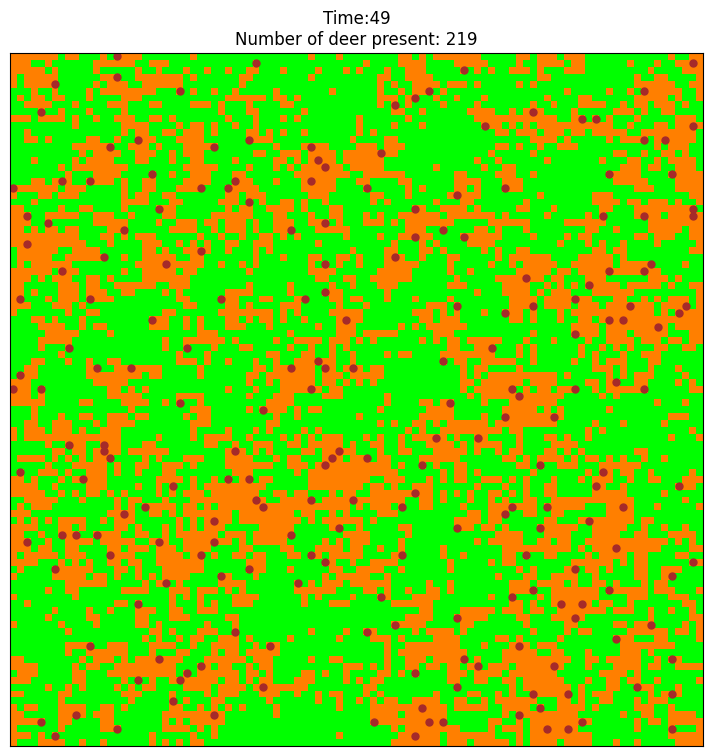

In [26]:
# sim = Grazing_simulation(10, 0.2, 5)

# for i in range(5):
#     sim.step()

    
n=100
q=0.35
num_deer = 300
arr = Grazing_simulation(n, q, num_deer)

# print(arr.grassland)

see = Animation2D(arr)
see.animate()
# see.show()
# arr.step()
# see.animate()

In [7]:
#MAKING THE DEER MOVE

#####################
# 1) get occupied locations (list)
# 2) get cardinal neighbors (list)
# 3) get cardinal neighbors in (2) that are not in (1). if length of list > 0 delete current position from occupied. else break and stay put
# 4) pick random cardinal neighbor in (3) and make it the deer's new position
# 5) add (4) to (1)


# it would help if we made a cardinal neighbor function in the Deer class


# THINGS WE NEED TO WORK ON:
# 1. regenerating the vegetation
# 2. making the deer 'smart' so they can choose where they should go based on the vegetation around them (Joseph sent me an email about this)
#    honestly after running a few simulations it does not seem realistic AT ALL that the entire deer population die in less than half the time 
#    steps :/ especially with all the vegetated cells still there




# CHANGES AND OBSERVATIONS MADE
# 1. CHANGE - lines 56 and 59 of the grazing simulation cell to make use of the metabolism parameter since that was a value we wanted to constatly change and measure sustainabilty
# 2. OBSERVATION - w/ metabolism at 9, weight gain = metabolism, and weight loss = metabolism * 1.5, steady state was at time step 34 w/ about 229 deer
# 3. OBSERVATION - w/ metabolism at 10, weight gain = metabolism, and weight loss = metabolism * 1.5, steady state was at time step 35 w/ about 219 deer

# Experiment Conclusion and Discussion

i guess we put our chart and blab about it here lol

# Algorithm Analysis
1. The introduce_deer method has a time complexity of O(n^2) because it loops through all the cells in the grid to create a list of available locations to place the deer, and then shuffles that list before selecting the first m items to create the deer. The step method has a time complexity of O(m\*n) because it loops through all the deer and their cardinal neighbors to move the deer. This could result in up to a O(n\*n), should the inputs result in deer occupying every cell (this is an edge case however, not the average case).

2. This means that the model will continue to grow exponentially as the size of the CA increases. Thus, it's important to take note of how expensive running this simulation would be for longer CA experiments.

3.